In [138]:
!uv pip install --upgrade langchain langchain-core langchain-openai langchain-community langchain-chroma langgraph

Resolved 121 packages in 210ms                                       
Audited 121 packages in 1ms


In [139]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [140]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [141]:
# StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    question: str
    answer: str
    context: List[Document]

In [142]:
# graph builder
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [143]:
# retriver node
def retrive(state: AgentState) -> AgentState:
    question = state["question"]
    docs = retriver.invoke(question)
    return {"context": docs}

In [144]:
from langchain_classic import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    content = state["context"]
    question = state["question"]
    rag_chain = generate_prompt | llm
    answer = rag_chain.invoke({"context": content, "question": question})

    print(f"answer: {answer.content}")
    return {"answer": answer.content}

In [145]:
# chekc docs node
from langchain_classic import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def relevance_doc(state: AgentState) -> Literal['relevant', 'irrelevant']:
    question = state["question"]
    context = state["context"]
    doc_relevance_chain = doc_relevance_prompt | llm
    relevance = doc_relevance_chain.invoke({"question": question, "documents": context})

    print(f"context: {context}")
    print(f"relevance: {relevance}")

    if relevance['Score'] == 1:
        return 'relevant'
    
    return 'irrelevant'


In [146]:
# rewrite node
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자", "세금과 관련된 표현 -> 누진세 포함"]

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{question}}
""")

def rewrite(state: AgentState):
    question = state["question"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    rewritten_question = rewrite_chain.invoke({"question": question})

    print(f"rewritten_question: {rewritten_question}")
    return {"question": rewritten_question}

In [147]:
# hallucination node
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template(f"""
You are a theache tasked with evaluation whether a studen's answer is based on facts or not,
Chech whether ther student's anser is hallucianted or not
given context, which are excerpts from income tax law, and a student's answer,
If the student's answer is based on facts, respond with "not hlluciated"
If the student's answer is not based on facts, respond with "hallucinated"
학생의 답변: {{student_answer}}
documents: {{documents}}
""")

hallucination_llm = ChatOpenAI(model="gpt-4o", temperature=0)

def chekc_hallucination(state: AgentState) -> Literal['not hallucinated', 'hallucinated']:
    answer = state["answer"]
    context = state["context"]
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({"student_answer": answer, "documents": context})

    print(f"context: {context}")
    print(f"response: {response}")
    
    return response

    


In [148]:
from langchain_classic import hub
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState):
    question = state["question"]
    answer = state["answer"]
    helpfulness_chain = helpfulness_prompt | llm
    response = helpfulness_chain.invoke({"question": question, "student_answer": answer})

    print(f"helpfulness: {response}")

    if response['Score'] == 1:
        return 'helpful'
    
    return 'not helpful'
    
    
def check_helpfulness(state: AgentState) -> Literal['helpful', 'not helpful']:
    return state

In [149]:
graph_builder.add_node("retrive", retrive)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("helpfulness", check_helpfulness)


In [150]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrive")
graph_builder.add_conditional_edges(
    "retrive",
    relevance_doc,
    {
        "relevant": "generate",
        "irrelevant": END
    }
)

graph_builder.add_conditional_edges(
    "generate",
    chekc_hallucination,
    {
        "not hallucinated": "helpfulness",
        "hallucinated": "generate"
    }
)

graph_builder.add_conditional_edges(
    "helpfulness",
    check_helpfulness_grader,
    {
        "helpful": END,
        "not helpful": 'rewrite'
    }
)

graph_builder.add_edge("rewrite", "retrive")


In [151]:
graph = graph_builder.compile()


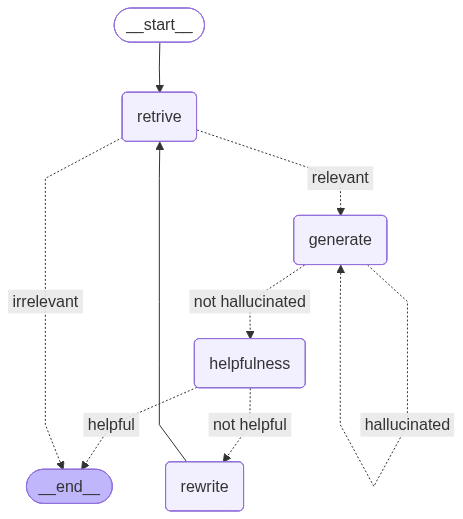

In [152]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [153]:
initial_state = {
    "question": "연봉 5천만원 거주자의 소득세는 얼마인가요?"
}

graph.invoke(initial_state)

context: [Document(id='176763a6-b0d9-4314-83bb-032dd06e2ff3', metadata={'source': './documents/income_tax.txt'}, page_content='<전문개정 2009. 12. 31.>  \n제57조(세액의 기산)\n<개정 2009. 12. 31.>  \n제1편 시행 <전문개정 2009. 12. 31.>\n소득세법\n제55조(세율)\n거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n과세표준\n| 과세표준     | 세  율               |\n|-----------|------------------|\n| 1,400만원 이하  | 각 세 표준의 6개 천분    |\n| 1,400만원 초과 ~ 5,000만원 이하 | 15% (1,400만원을 초과하는 금액의 15%천분) |\n| 5,000만원 초과 ~ 8,000만원 이하 | 24% (5,000만원을 초과하는 금액의 24%천분) |\n| 8,000만원 초과 ~ 1억5천만원 이하 | 35% (8,800만원을 초과하는 금액의 35%천분) |\n| 1억5천만원 초과 ~ 3억원 이하 | 38% (1억5천만원을 초과하는 금액의 38%천분) |\n| 3억원 초과 ~ 5억원 이하 | 40% (3억원을 초과하는 금액의 40%천분) |\n| 5억원 초과 | 42% (5억원을 초과하는 금액의 42%천분) |\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 “퇴직소득 산출세액”이라 한다)으로 한다. <개정 2013. 1. 1., 2014. 12. 23.>\n1. 해당 과세기간의 퇴직소득과세표준에 제1항의 세율을 적용하여 계산한 금액\n2. 삭제<2014. 12. 23

{'question': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'answer': '연봉 5천만 원 거주자의 소득세는 해당 금액 중 1,400만 원을 초과하는 부분에 대해 15%의 세율이 적용됩니다. 따라서, 5천만 원에서 1,400만 원을 뺀 3,600만 원에 대해 15%의 세금, 즉 540만 원이 산출됩니다.',
 'context': [Document(id='176763a6-b0d9-4314-83bb-032dd06e2ff3', metadata={'source': './documents/income_tax.txt'}, page_content='<전문개정 2009. 12. 31.>  \n제57조(세액의 기산)\n<개정 2009. 12. 31.>  \n제1편 시행 <전문개정 2009. 12. 31.>\n소득세법\n제55조(세율)\n거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n과세표준\n| 과세표준     | 세  율               |\n|-----------|------------------|\n| 1,400만원 이하  | 각 세 표준의 6개 천분    |\n| 1,400만원 초과 ~ 5,000만원 이하 | 15% (1,400만원을 초과하는 금액의 15%천분) |\n| 5,000만원 초과 ~ 8,000만원 이하 | 24% (5,000만원을 초과하는 금액의 24%천분) |\n| 8,000만원 초과 ~ 1억5천만원 이하 | 35% (8,800만원을 초과하는 금액의 35%천분) |\n| 1억5천만원 초과 ~ 3억원 이하 | 38% (1억5천만원을 초과하는 금액의 38%천분) |\n| 3억원 초과 ~ 5억원 이하 | 40% (3억원을 초과하는 금액의 40%천분) |\n| 5억원 초과 | 42% (5억